In [3]:
# importowanie potrzebnych bibliotek:

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
#-------------------------------------------------------
from rdkit.Chem import AllChem
from rdkit import Chem
from rdkit.DataStructs.cDataStructs import ExplicitBitVect
from rdkit.Avalon import pyAvalonTools
from rdkit.Chem import PandasTools
from rdkit.Chem import rdMolDescriptors
from tqdm import tqdm
#--------------------------------------------------------
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.ensemble import RandomForestRegressor
import time
from sklearn.model_selection import ShuffleSplit, cross_validate,train_test_split
#--------------------------------------------------------
from lightgbm import LGBMRegressor

In [35]:
termo_database = pd.read_excel('C:/Users/mbkil/excele/Database _500.xlsx') 
termo_database.head()

# importujemy wykonaną przez nas baze danych

,Unnamed: 0,CAS,Substances,Molecular Weight [g/mol],Formula,SMILES,Critical_Temperature,Critical_Pressure,Critical_Volume
0,1,74-82-8,Methane,16.04,CH4,C,173.70,4599.0,0.099
1,2,74-84-0,Ethane,30.07,C2H6,CC,304.26,4580.0,0.145
2,3,74-98-6,Propane,44.10,C3H8,CCC,364.59,4242.6,0.198
3,4,106-97-8,Butane,58.12,C4H10,CCCC,423.90,3787.0,0.255
4,5,109-66-0,Pentane,72.15,C5H12,CCCCC,469.70,3370.0,0.295


In [36]:
termo_baza_podstawa = termo_database[["Critical_Temperature","Critical_Pressure","Critical_Volume","SMILES"]]
termo_baza_podstawa

# wyodrębniamy interesujące nas dane

,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES
0,173.70,4599.00,0.099,C
1,304.26,4580.00,0.145,CC
2,364.59,4242.60,0.198,CCC
3,423.90,3787.00,0.255,CCCC
4,469.70,3370.00,0.295,CCCCC
...,...,...,...,...
495,549.00,3970.00,0.324,CC(C)(C)CO
496,577.20,3930.00,0.329,CC(C)CCO
497,570.76,3916.03,0.329,CCC(C)CO
498,504.03,3431.89,0.328,CCC(C)OC


In [37]:
# tworzymy struktury 2d dla naszych SMILESÓW
PandasTools.AddMoleculeColumnToFrame(termo_baza_podstawa,'SMILES','Stucture',includeFingerprints=True)

C:\Users\mbkil\anaconda3\lib\site-packages\rdkit\Chem\PandasTools.py:381: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  frame[molCol] = frame[smilesCol].map(


,Critical_Temperature,Critical_Pressure,Critical_Volume,SMILES,Stucture
0,173.70,4599.00,0.099,C,
1,304.26,4580.00,0.145,CC,
2,364.59,4242.60,0.198,CCC,
3,423.90,3787.00,0.255,CCCC,
4,469.70,3370.00,0.295,CCCCC,
...,...,...,...,...,...
495,549.00,3970.00,0.324,CC(C)(C)CO,
496,577.20,3930.00,0.329,CC(C)CCO,
497,570.76,3916.03,0.329,CCC(C)CO,
498,504.03,3431.89,0.328,CCC(C)OC,

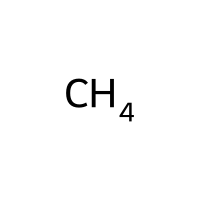
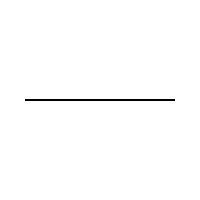
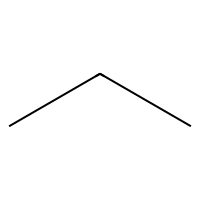
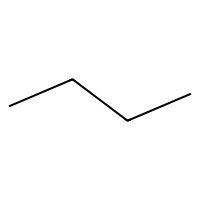
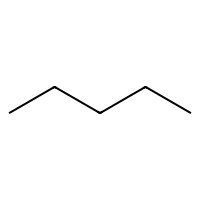
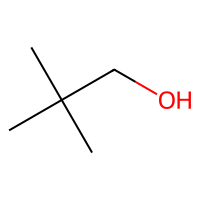
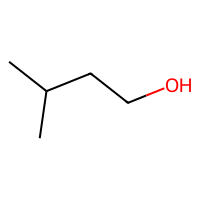
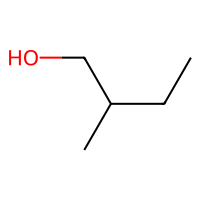
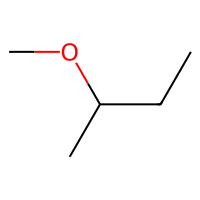
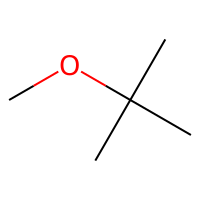

In [38]:
termo_baza_podstawa

In [39]:
def generate_AVfpts(data):
    
    Avalon_fpts = []
    
    for mol in tqdm(data):
      
        avfpts = pyAvalonTools.GetAvalonFP(mol, nBits=512)
        Avalon_fpts.append(avfpts)
        
    return np.array(Avalon_fpts)

# Tworzymy fingerprinty

In [40]:
Avalon_fpts = generate_AVfpts(termo_baza_podstawa['Stucture'])

100%|██████████| 500/500 [00:00<00:00, 3275.99it/s]


In [48]:
# Przchowujemy fingerprinty w nowej bazie

Avalon_fingerprints = pd.DataFrame(Avalon_fpts, columns=['Col_A_{}'.format(i + 1) 
                                                        for i in range(Avalon_fpts.shape[1])])
Avalon_fingerprints

Avalon_fingerprints.to_excel("Avalon_fingerprints.xlsx", index=False)

In [42]:
# Ustawiamy model:
lgbm_av = LGBMRegressor(n_estimators=800, random_state=42)
model_rf = RandomForestRegressor(random_state=42)

In [43]:
# Czas startu:
start = time.time()

# Walidacja krzyżowa:
cv = ShuffleSplit(n_splits=10, test_size=0.2,random_state=42)
scoring = ['r2','neg_mean_absolute_error']

scores_val = cross_validate(lgbm_av, Avalon_fingerprints,  termo_baza_podstawa.Critical_Temperature, scoring=scoring, cv=cv)

print(scores_val)

time.sleep(50)
# get the end time
end = time.time()

# get the execution time
total_time = end - start
print('Total time required:', round(total_time/60, 2), 'min') 

{'fit_time': array([0.42087293, 0.40890574, 0.4198761 , 0.37100792, 0.40790892,
       0.41588593, 0.37100744, 0.39993024, 0.37000966, 0.36003709]), 'score_time': array([0.00997353, 0.00897622, 0.01097059, 0.00897598, 0.00897574,
       0.00897551, 0.00997376, 0.00897717, 0.01097178, 0.01196837]), 'test_r2': array([0.77135243, 0.5388946 , 0.69824732, 0.64753624, 0.73591846,
       0.77774959, 0.69929293, 0.69924775, 0.74798758, 0.58251508]), 'test_neg_mean_absolute_error': array([-25.745359  , -24.04770242, -20.66268828, -24.1312275 ,
       -22.00347965, -23.24112544, -24.35369342, -22.85332091,
       -21.07151034, -30.46287783])}
Total time required: 0.9 min


In [44]:
# R^2 of coefficient of determination of tenfold cross validation
scores_val['test_r2']

array([0.77135243, 0.5388946 , 0.69824732, 0.64753624, 0.73591846,
       0.77774959, 0.69929293, 0.69924775, 0.74798758, 0.58251508])

In [45]:
# Mean absolute error (MAE) of the tenfold cross validation values
-scores_val['test_neg_mean_absolute_error']

array([25.745359  , 24.04770242, 20.66268828, 24.1312275 , 22.00347965,
       23.24112544, 24.35369342, 22.85332091, 21.07151034, 30.46287783])

In [46]:
# Mean values of tenfold cross-validation values of R^2 and MAE 
# Using lightGBM

print("R^2 :", round(np.mean(scores_val['test_r2']), 2))
print("MAE :", round(np.mean(-scores_val['test_neg_mean_absolute_error']), 2))

R^2 : 0.69
MAE : 23.86
